In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

runlist=[1414, 1415, 1416, 1417, 1418] # Select runs with bias scans
bias = np.array([0, 1, -1, -0.5, 0.5])

In [2]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist, userunlist=True, remove=False)
arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree

In [3]:
list_febID = arr['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root
Number of FEBs: 6
List of FEBs: [22, 25, 17, 14, 20, 1]


In [4]:
if not np.array_equal(np.array(runlist), arr['runNumber'].to_numpy()):
    print("Input run list order and data do not match")

In [5]:
#Mask channels which were not calibrated
arSPE = ak.mask(arr['calibConstantsTemperatureCorrected'], arr['calibConstantsTemperatureCorrected']>0).to_numpy()

Bad channel: 33


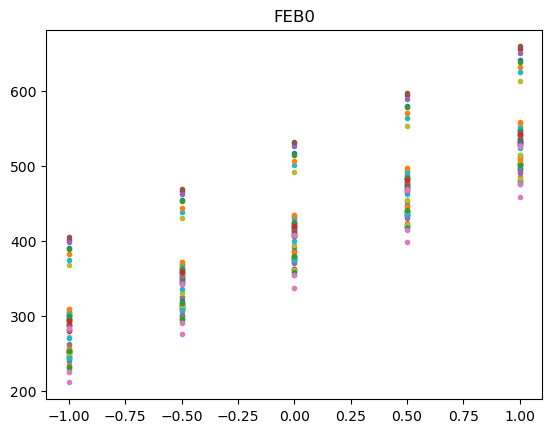

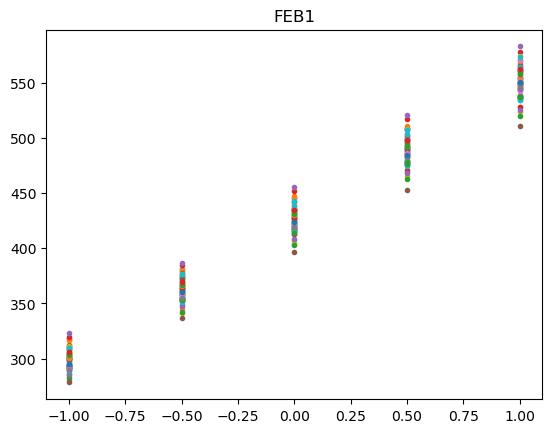

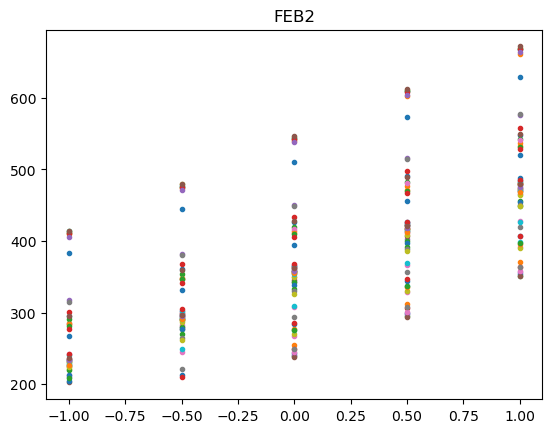

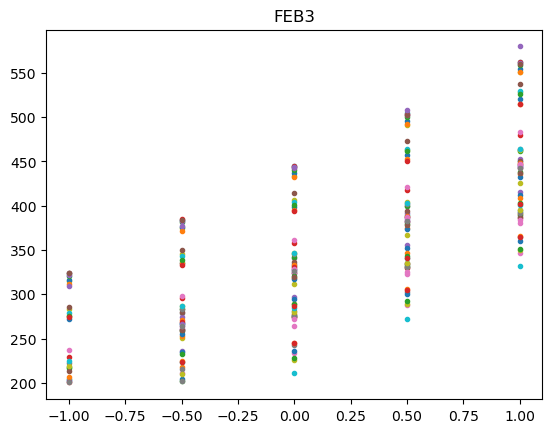

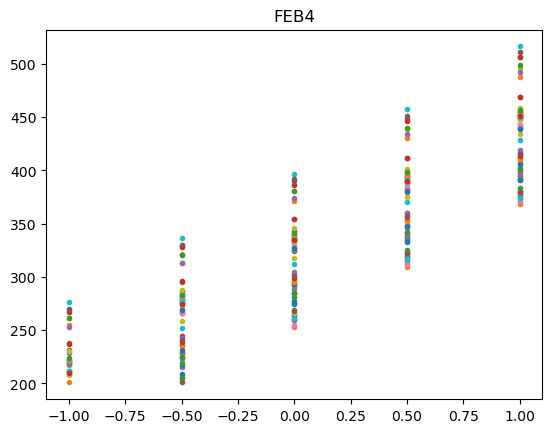

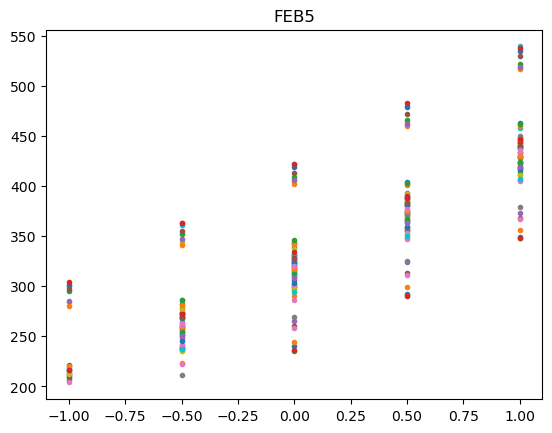

In [16]:
goal_overV = 3
df = pd.DataFrame(columns=['feb', 'chan', 'slope', 'intercept', "overV", "offsetV"])
for feb in range(NFEBS):
    plt.figure()
    plt.title("FEB%d"%feb)
    for chan in range(64):
        x=bias
        y=arSPE[:,feb,chan]
        mask = ~np.isnan(y)
        x=x[mask]
        y=y[mask]
        plt.plot(x, y, '.');
        if y.size==0:
            print("Bad channel: %d"%chan)
            continue
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        new_row = {'feb': feb, 'chan': chan, 'slope': slope, 'intercept': intercept, 
                   'overV': intercept/slope, 'offsetV': intercept/slope-goal_overV}
        df.loc[len(df)] = new_row

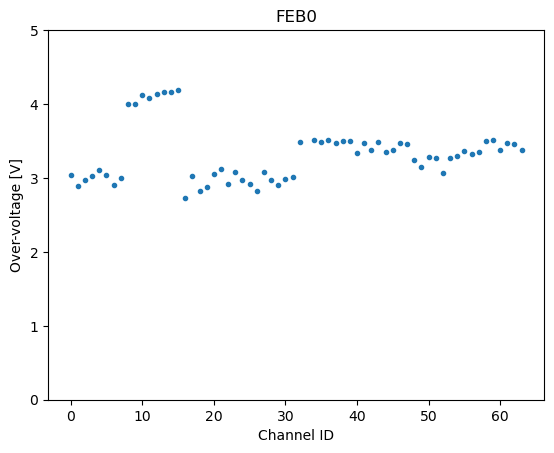

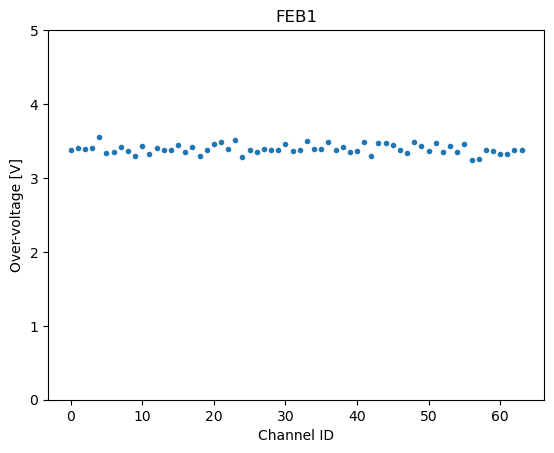

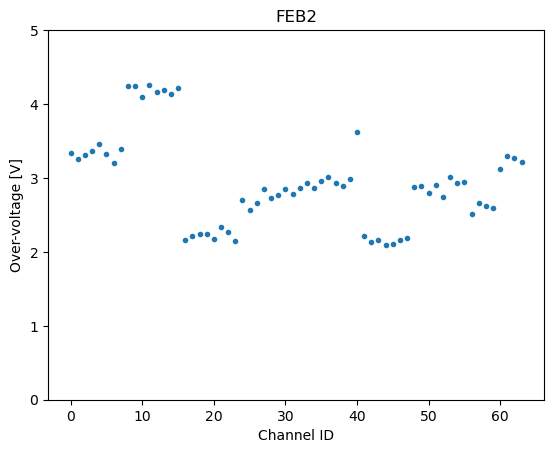

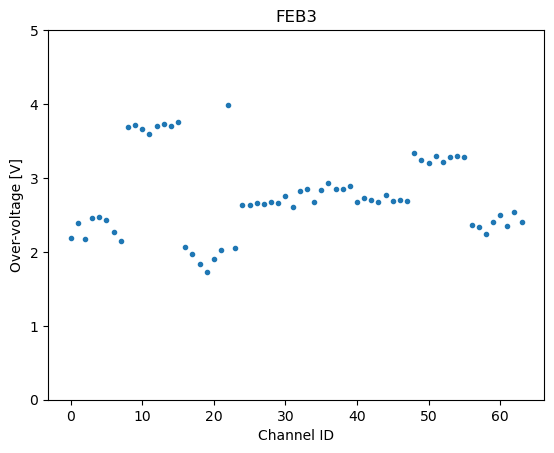

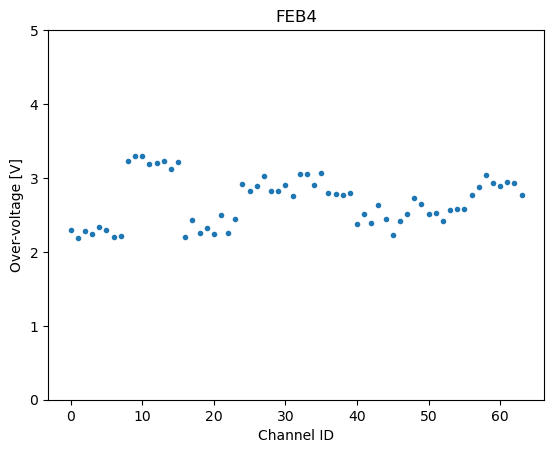

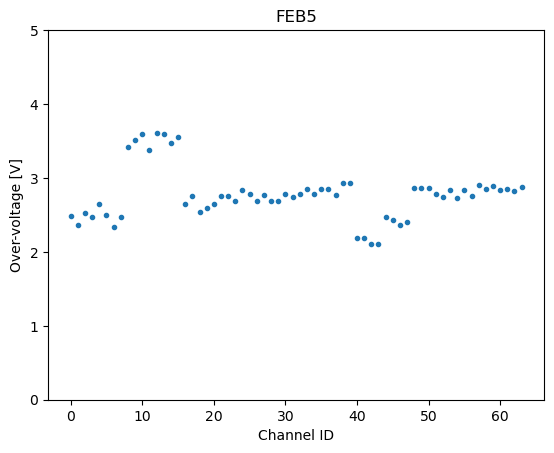

In [10]:
for feb in range(NFEBS):
    plt.figure()
    plt.title("FEB%d"%feb)
    plt.plot(df.query("feb==%d"%feb)['chan'], df.query("feb==%d"%feb)['overV'], '.')
    plt.xlabel("Channel ID")
    plt.ylabel("Over-voltage [V]")
    plt.ylim(0,5)

In [17]:
df[['chan', 'offsetV']]

,chan,offsetV
0,0,0.045445
1,1,-0.114621
2,2,-0.029221
3,3,0.031999
4,4,0.107207
...,...,...
378,59,-0.103767
379,60,-0.158911
380,61,-0.150625
381,62,-0.179119
